# Notebook to Investigate LSTM Performance Variance for Maritime Only Single Snow Type Model - UCLA Data 

# Step 0 - Set up Notebook

In [1]:
# import needed libaries
import os
import boto3
import mlflow
import time
from PIL import Image
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from snowML.viz import download_metrics as dm
from snowML.datapipe.utils import snow_types as st
from snowML.datapipe.utils import get_geos as gg
from snowML.datapipe.utils import data_utils as du
from snowML.datapipe.utils import get_dem as gd

In [2]:
# initialize erathengine credentials
import ee
ee.Authenticate()

True

# Step1 - Get MLFlow Metrics

In [3]:
run_dict = {} 
run_dict["mar_mse_stop_.9_UCLA"] = "ea32c63fd02840e3ab28e7cd7a5a9736"


run_dict

{'mar_mse_stop_.9_UCLA': 'ea32c63fd02840e3ab28e7cd7a5a9736'}

In [4]:
# create a dictionary of dataframes corresponding to the run_id shortname uploading from local files 
# Assumes you have already run the "download metrics" script from the snowML.Scripts package to save the metrics to local files
df_dict = {}
for key in run_dict.keys(): 
    run_id = run_dict[key]
    file = f"../../mlflow_data/run_id_data/metrics_from_{run_id}.csv"
    df_metrics = pd.read_csv(file)
    #print(df_metrics.shape)
    df_dict[key] = df_metrics


In [5]:
# display example
key = "mar_mse_stop_.9_UCLA"
df_metrics = df_dict[key]
print(df_metrics.shape)
df_metrics.head(2)


(2104, 3)


,Metric,Step,Value
0,test_kge_171100051001,0,0.586291
1,test_r2_171100051001,0,0.578038


# Step 2 - Functions to Summarize Metrics 

In [6]:
# function to extract only a specific metric by suffix
def extract_metric_by_suffix(df, metric_name, step = False):
    """Extracts rows where the Metric column ends with 'metric_name' and returns only Metric, Valuem and optionally Step columns."""
    if step: 
        return df[df['Metric'].str.endswith(metric_name)][['Metric', "Step",'Value']].sort_values(by='Metric')
    else: 
        return df[df['Metric'].str.endswith(metric_name)][['Metric', 'Value']].sort_values(by='Metric')

In [7]:
# function to extract only a specific metric by prefix
def extract_metric_by_prefix(df, prefix, step=False):
    """Extracts rows where the Metric column begins with 'prefix' and returns only Metric, Value and optionally step columns."""
    if step:
        return df[df['Metric'].str.startswith(prefix)][['Metric', "Step", 'Value']].sort_values(by='Metric')
    else:
        return df[df['Metric'].str.startswith(prefix)][['Metric', 'Value']].sort_values(by='Metric')

In [8]:
# function to extract only the last epoch 
def filter_to_last_step_per_metric(df):
    """
    Filters the DataFrame to include only rows where 'step' is the maximum for each 'metric'.
    
    Parameters:
        df (pd.DataFrame): A DataFrame with columns 'metric', 'step', and 'value'.
        
    Returns:
        pd.DataFrame: Filtered DataFrame with only the last step for each metric.
    """
    return df[df["Step"] == df.groupby("Metric")["Step"].transform("max")]



Examples 

In [9]:
df_kge = extract_metric_by_prefix(df_metrics, "test_kge", step = True)
#df_kge[df_kge["Metric"] == "test_kge_171100051001"]
df_kge.head()

,Metric,Step,Value
1207,test_kge_170200090101,7,0.760705
1206,test_kge_170200090101,6,0.730943
1205,test_kge_170200090101,5,0.849592
1204,test_kge_170200090101,4,0.677580
1203,test_kge_170200090101,3,0.684764


In [10]:
df_kge_last = filter_to_last_step_per_metric(df_kge)
df_kge_last.head()

,Metric,Step,Value
1208,test_kge_170200090101,8,0.801176
1169,test_kge_170200090102,2,0.874398
1040,test_kge_170200090103,0,0.722972
1152,test_kge_170200090104,0,0.791839
1087,test_kge_170200090105,0,0.707379


In [11]:
df_sorted = df_kge_last.sort_values("Value")
df_sorted.head()

,Metric,Step,Value
1476,test_kge_170200110307,2,-0.404012
545,test_kge_171100080108,0,-0.120688
1951,test_kge_170200110305,0,-0.041023
831,test_kge_171100080107,0,0.028245
1677,test_kge_171100050405,2,0.050891


In [12]:
df_kge_last.describe()

,Step,Value
count,152.000000,152.000000
mean,0.730263,0.490931
std,1.973233,0.230067
min,0.000000,-0.404012
25%,0.000000,0.344285
50%,0.000000,0.518279
75%,0.000000,0.673035
max,9.000000,0.887333


# Step 3- Compare Runs

In [13]:
def assemble_summary(run_dict, metric_nm): 
    df_summary_dict = {}
    for key in run_dict.keys(): 
        df_metrics = df_dict[key]
        df_filtered = extract_metric_by_prefix(df_metrics, metric_nm, step=True)
        df_metric_last = filter_to_last_step_per_metric(df_filtered)

        # Set the index to the 'metric' column
        df_metric_last = df_metric_last.set_index("Metric")

        # Append the key to all other column names (except the index)
        df_metric_last = df_metric_last.add_suffix(f"_{key}")
        df_metric_last.columns = df_metric_last.columns.str.replace("Value", metric_nm)

        # Store in the summary dictionary
        df_summary_dict[key] = df_metric_last

    # Concatenate all DataFrames on the index (metric)
    df_summary = pd.concat(df_summary_dict.values(), axis=1)

    return df_summary


In [14]:
def slim_by_prefix(df, prefix):
    """
    Returns a new DataFrame containing only the columns whose names start with the given prefix.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame.
        prefix (str): Column prefix to filter by (e.g., "Test_KGE").
        
    Returns:
        pd.DataFrame: Filtered DataFrame with only matching columns.
    """
    slim_cols = [col for col in df.columns if col.startswith(prefix)]
    return df[slim_cols].copy()


In [15]:
df_summary = assemble_summary(run_dict, "test_kge")
df_summary.head()

,Step_mar_mse_stop_.9_UCLA,test_kge_mar_mse_stop_.9_UCLA
Metric,,
test_kge_170200090101,8,0.801176
test_kge_170200090102,2,0.874398
test_kge_170200090103,0,0.722972
test_kge_170200090104,0,0.791839
test_kge_170200090105,0,0.707379


In [16]:
df_summary_slim = slim_by_prefix(df_summary, "test_kge")
df_summary_slim.describe()

,test_kge_mar_mse_stop_.9_UCLA
count,152.000000
mean,0.490931
std,0.230067
min,-0.404012
25%,0.344285
50%,0.518279
75%,0.673035
max,0.887333


# Step 4 - Plot 

In [17]:
def plot_metric_boxplots(df, prefix="test_kGE"):
    """
    Plots boxplots for all columns in the DataFrame that start with the given prefix.
    Uses the remainder of the column name (after the prefix + underscore) as the label.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame.
        prefix (str): The prefix to filter columns by (e.g., 'Test_KGE', 'Test_MSE').
    """
    # Ensure prefix ends with "_" for clean suffix extraction
    prefix = prefix.rstrip("_") + "_"

    # Filter relevant columns
    metric_cols = [col for col in df.columns if col.startswith(prefix)]

    if not metric_cols:
        print(f"No columns found with prefix '{prefix}'")
        return

    # Reshape to long format
    df_long = df[metric_cols].copy()
    df_long = df_long.melt(var_name="Metric", value_name="Value")

    # Clean up the Metric labels
    df_long["Metric"] = df_long["Metric"].str.replace(prefix, "", regex=False)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_long, x="Metric", y="Value")
    plt.xticks(rotation=45)
    plt.title(f"{prefix.strip('_')} by Strategy")
    plt.tight_layout()
    plt.show()


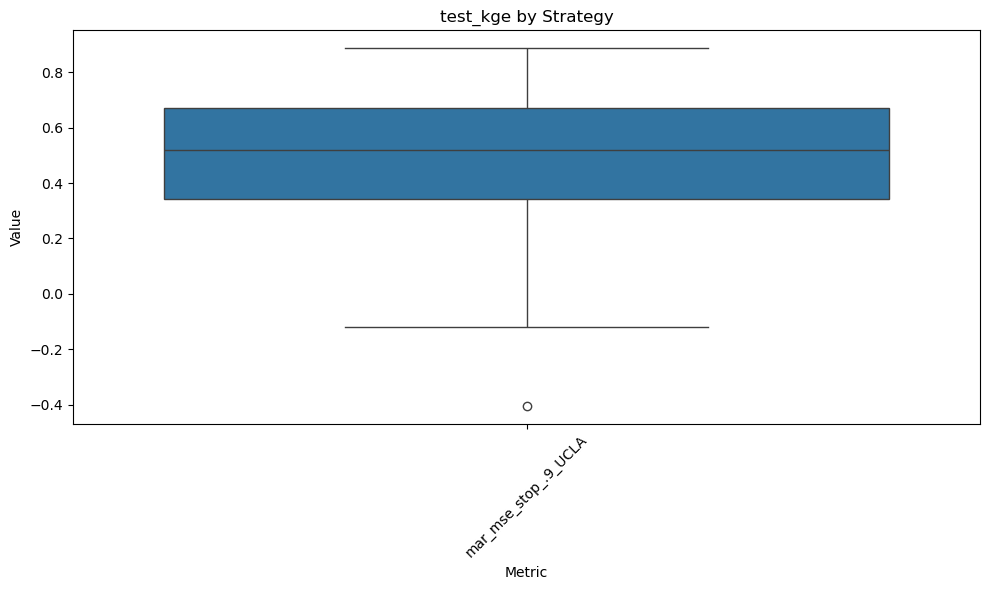

In [18]:
plot_metric_boxplots(df_summary, prefix="test_kge")

# Step 5 Compare to Results By Epoch No_stop Run 

In [19]:
run_dict_no_stop = {}


In [20]:
# create a dictionary of dataframes corresponding to the run_id shortname uploading from local files 
# Assumes you have already run the "download metrics" script from the snowML.Scripts package to save the metrics to local files
df_dict_no_stop = {}
for key in run_dict_no_stop.keys(): 
    run_id = run_dict_no_stop[key]
    file = f"../../mlflow_data/run_id_data/metrics_from_{run_id}.csv"
    df_metrics = pd.read_csv(file)
    #print(df_metrics.shape)
    df_dict_no_stop[key] = df_metrics

In [21]:
#key = "Mar_mse"
#metric_nm = "test_kge"
df_metrics = df_dict_no_stop[key]
df_filtered = extract_metric_by_prefix(df_metrics, "test_kge", step=True)
df_epoch_0 =  df_filtered[df_filtered["Step"] == 0]
# Set the index to the 'metric' column
df_epoch_0 = df_epoch_0.set_index("Metric")
# Append the key to all other column names (except the index)
df_epoch_0 = df_epoch_0.add_suffix(f"_{key}")
df_epoch_0.columns = df_epoch_0.columns.str.replace("Value", metric_nm)
df_epoch_0.head()

# Concatenate all DataFrames on the index (metric)
df_summary_all = pd.concat([df_summary, df_epoch_0], axis=1)
df_summary_all.head()



KeyError: 'mar_mse_stop_.9_UCLA'

In [ ]:
df_summary_all_slim = slim_by_prefix(df_summary_all, "test_kge")
df_summary_all_slim.describe()


In [ ]:
plot_metric_boxplots(df_summary_all, prefix="test_kge")